# Plot Paloma data

## Imports and setup

In [1]:
import json
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import wandb

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)


def format_ticks(x, pos):
    return str(int(x // 1000))


wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yw580 (pico-lm). Use `wandb login --relogin` to force relogin


True

## Get data from runs

In [2]:
api = wandb.Api()

RUN_SCALE = "tiny"

runs = [
    api.run("pico-lm/pico-decoder/lne20rc1"),  # pico decoder tiny
    api.run("pico-lm/pico-relora/6vhmv4aj"),  # pico relora tiny
    api.run("pico-lm/pico-decoder/kzcalg17"),  # small
    api.run("pico-lm/pico-relora/5urfvs2j"),
]

dfs: list[pd.DataFrame] = []


def _get_data(scale):
    for i in range(0, 20_001, 1_000):
        path = Path(f"blimp_results_{scale}/step_{i}.json")
        with path.open() as f:
            data = json.load(f)
        if "blimp" in data:
            data = data["blimp"]
        yield (i, data["accuracy"])


for ridx, run in enumerate(runs):
    df = pd.DataFrame(run.scan_history())
    is_decoder = ridx % 2 == 0
    df["Model"] = rf"\texttt{{pico-{'decoder' if is_decoder else 'relora'}}}"
    scale = "tiny" if ridx < 2 else "small"
    df["Scale"] = scale

    if is_decoder:
        df_to_merge = pd.DataFrame(_get_data(scale), columns=["trainer/global_step", "eval/blimp"])
        df = pd.merge(df, df_to_merge, how="left", on="trainer/global_step")

    dfs.append(df)

In [3]:
MAX_TIME = pd.Timedelta("800h")
MAX_TIME_HRS = MAX_TIME.total_seconds() / 3600
INTERVAL = pd.Timedelta("20h")

In [4]:
time_dfs: list[pd.DataFrame] = []
for df in dfs:
    run_df = df.copy()

    run_df["n_gpus"] = run_df.apply(lambda row: 16 if "decoder" in row["Model"] else 4, axis=1)
    run_df["_runtime"] = pd.to_timedelta(run_df["_runtime"], unit="s")
    run_df["_runtime"] = run_df["_runtime"] - run_df["_runtime"].iloc[0]
    run_df["gpu_time"] = (run_df["_runtime"].dt.total_seconds() / 3600) * run_df["n_gpus"]
    time_dfs.append(run_df)

runtime_data = pd.concat(time_dfs, ignore_index=True)


runtime_data.rename(
    columns={"eval/paloma": "PPL", "train/loss": "Loss", "eval/blimp": "BLiMP"}, inplace=True
)

runtime_data = runtime_data.drop(columns=runtime_data.filter(regex="^blimp/").columns)
runtime_data = runtime_data.drop(columns=runtime_data.filter(regex="^relora/").columns)


runtime_data = runtime_data[runtime_data["gpu_time"] <= MAX_TIME_HRS]

In [5]:
runtime_data[runtime_data["Model"] == r"\texttt{pico-decoder}"]["BLiMP"].notna().sum()

np.int64(156)

In [6]:
def plot_metric(metric: str):
    colors = ["#1E88E5", "#FF992F"]
    models = sorted(runtime_data["Model"].unique().tolist())
    palette = dict(zip(models, colors))

    font_scale = 3

    sns.set_theme(font_scale=font_scale, rc={"axes.grid": "True", "axes.grid.which": "both"})

    g = sns.FacetGrid(
        data=runtime_data,
        col="Scale",
        # row="Metric",
        height=6,
        aspect=1.1,
        sharey=True,
        sharex=True,
        margin_titles=False,
    )

    g.map_dataframe(sns.lineplot, x="gpu_time", y=metric, hue="Model", palette=palette)

    g.set_titles(col_template=r"Scale = \texttt{{{col_name}}}")

    for axid, ax in enumerate(g.axes.flat):
        if metric == "PPL":
            ax.set_ylim(0, 2000)
        elif metric == "Loss":
            if axid == 0:
                ax.legend(bbox_to_anchor=(1, 1), loc="upper right")
            ax.set_ylim(3, 11.5)

    g.set_axis_labels("GPU Hours", metric)

    plt.tight_layout()

    plt.savefig(f"../graphs/training-{metric.lower()}-gpu.pdf", bbox_inches="tight")
    plt.show()

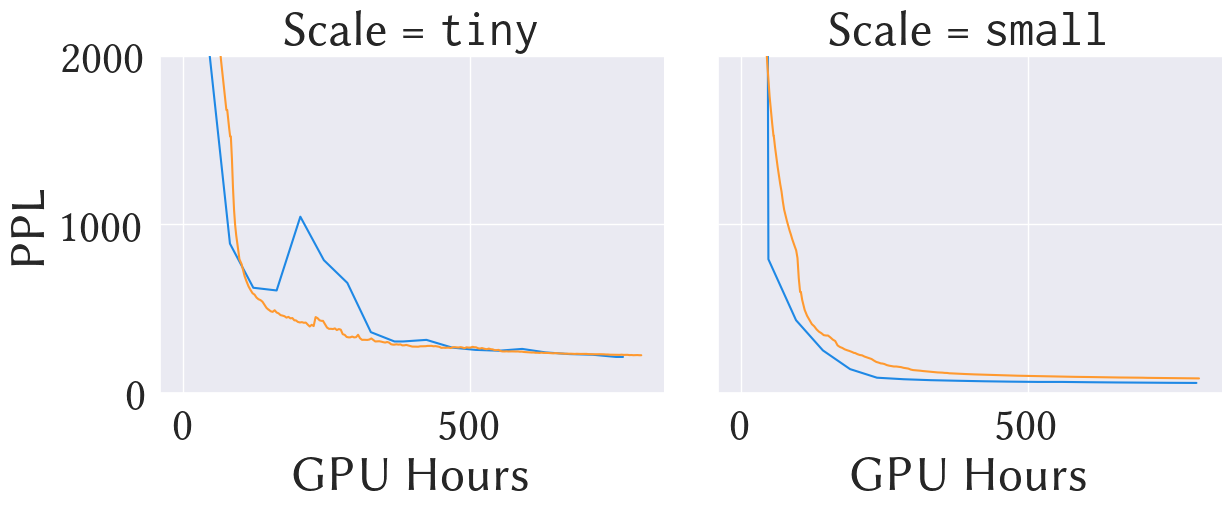

In [7]:
plot_metric("PPL")

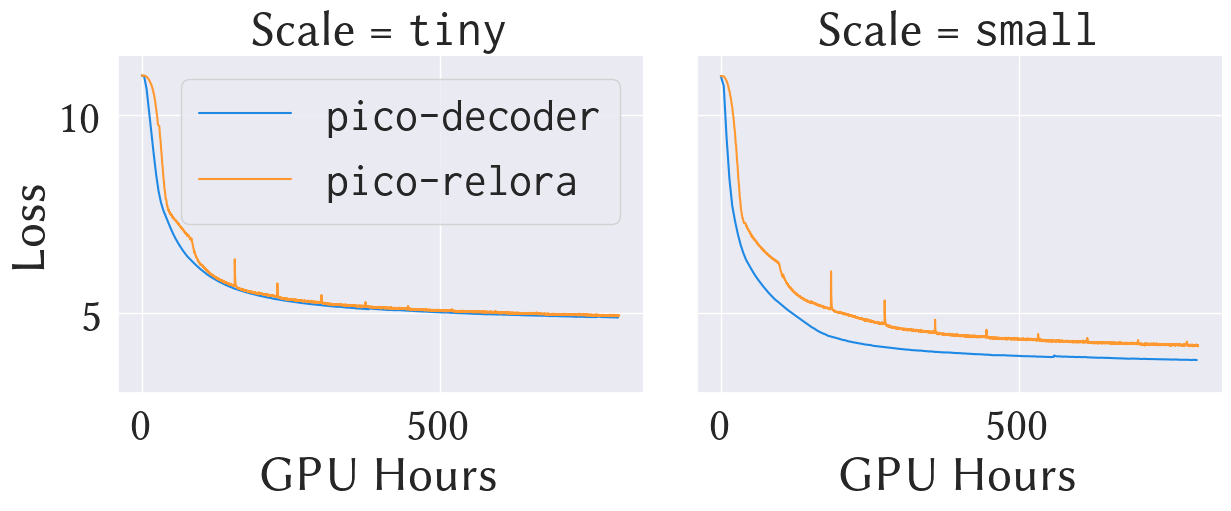

In [8]:
plot_metric("Loss")

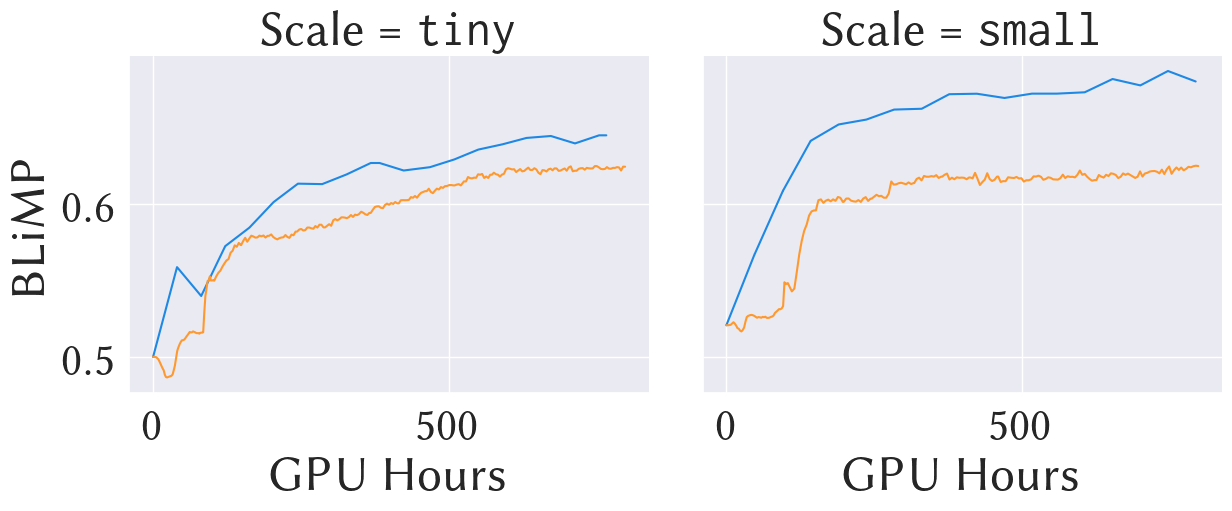

In [9]:
plot_metric("BLiMP")

In [11]:
f_run_data = runtime_data[
    runtime_data["PPL"].notna() | runtime_data["Loss"].notna() | runtime_data["BLiMP"].notna()
]

loss_data = f_run_data[["gpu_time", "Loss", "Model", "Scale"]].dropna().rename(columns={"Loss": "Value"})
loss_data["Metric"] = "Loss"

ppl_data = f_run_data[["gpu_time", "PPL", "Model", "Scale"]].dropna().rename(columns={"PPL": "Value"})
ppl_data["Metric"] = "PPL"

blimp_data = f_run_data[["gpu_time", "BLiMP", "Model", "Scale"]].dropna().rename(columns={"BLiMP": "Value"})
blimp_data["Metric"] = "BLiMP"

# Concatenate the dataframes
combined_data = pd.concat([loss_data, ppl_data, blimp_data], ignore_index=True)
# combined_data = combined_data[combined_data["trainer/global_step"] <= 20_000]

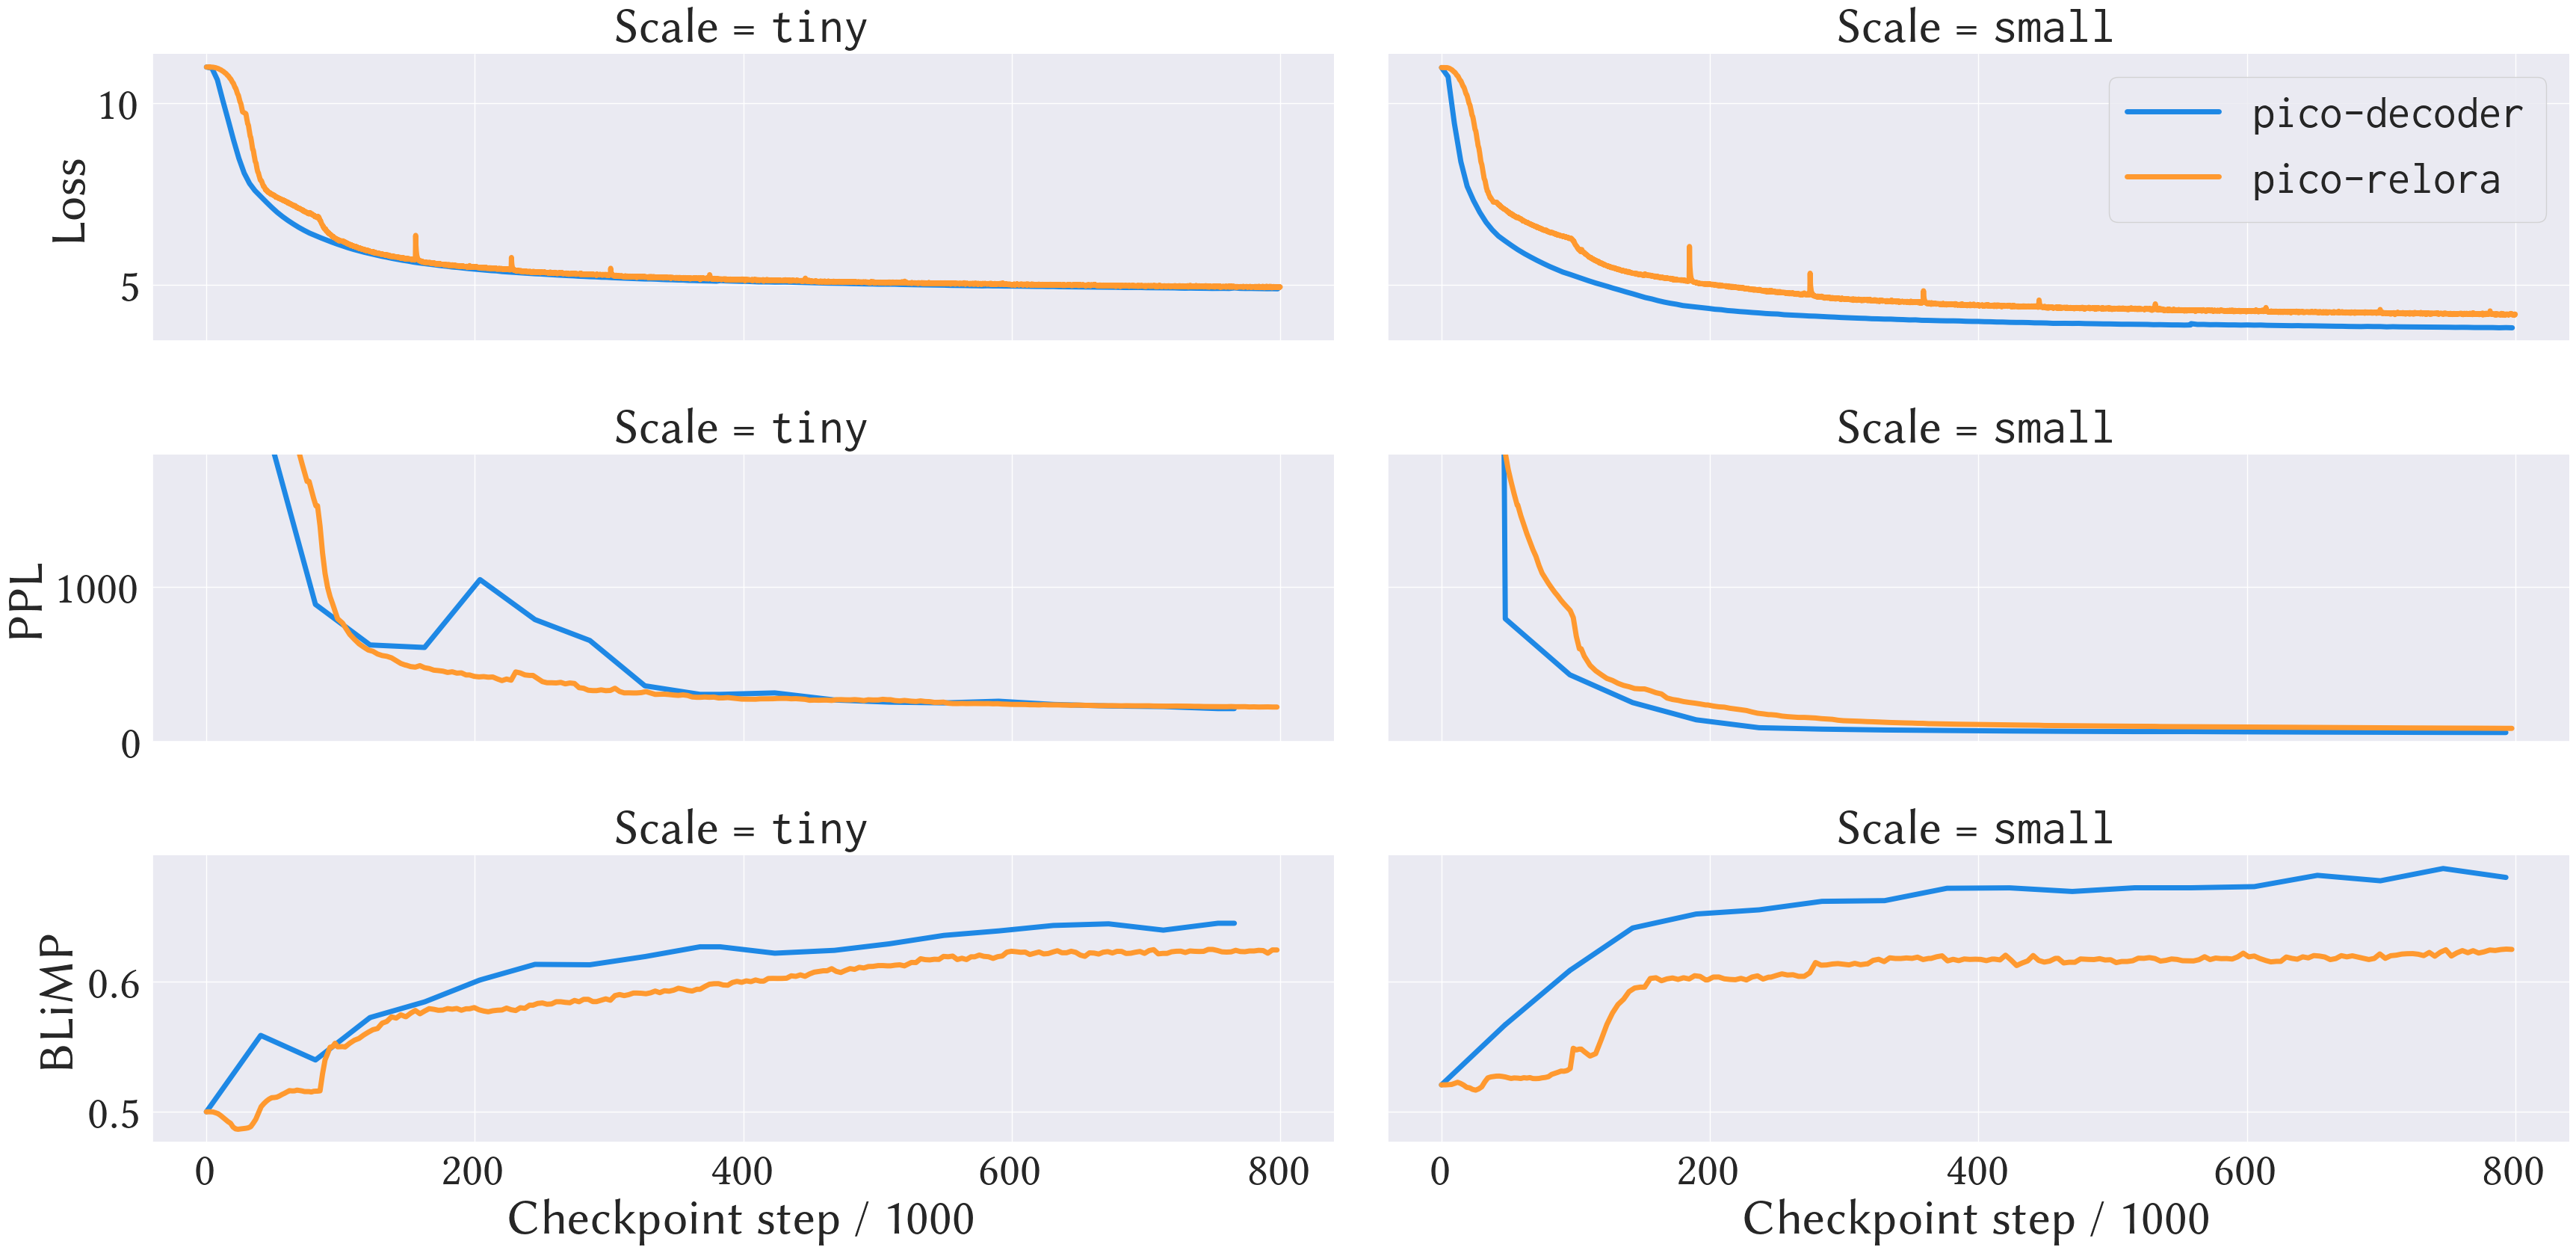

In [15]:
colors = ["#1E88E5", "#FF992F"]
models = sorted(combined_data["Model"].unique().tolist())
palette = dict(zip(models, colors))

dodge = 0.4
size = 8
font_scale = 4

sns.set_theme(font_scale=font_scale, rc={"axes.grid": "True", "axes.grid.which": "both"})

g = sns.FacetGrid(
    data=combined_data.drop_duplicates(),
    col="Scale",
    row="Metric",
    height=6,
    aspect=3,
    sharey="row",
    sharex=True,
    margin_titles=False,
)

g.map_dataframe(sns.lineplot, x="gpu_time", y="Value", hue="Model", palette=palette, linewidth=5)


for i, ax_row in enumerate(g.axes):
    for ax in ax_row:
        if i == 0:  # First row (Loss)
            ax.set_ylabel("Loss")
        elif i == 1:  # Second row (PPL)
            ax.set_ylabel("PPL")
        else:
            ax.set_ylabel("BLiMP")

        if "tiny" in ax.get_title().lower():
            ax.set_title(r"Scale = \texttt{tiny}")
        elif "small" in ax.get_title().lower():
            ax.set_title(r"Scale = \texttt{small}")

for axid, ax in enumerate(g.axes.flat):
    # ax.set_xticks(range(0, 20_001, 2_000), labels=None if axid <= 3 else range(0, 21, 2))
    if axid in (2, 3):
        ax.set_ylim(0, 1850)
    elif axid == 1:
        ax.legend(bbox_to_anchor=(1, 1), loc="upper right")


g.set_axis_labels("Checkpoint step / 1000")

plt.savefig("../graphs/training-gpu-hrs.pdf", bbox_inches="tight")
plt.show()